In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA

In [0]:
df= pd.read_csv("/content/drive/My Drive/Courswork/sales_train_validation.csv")

In [0]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,3,1,3,1,2,2,0,1,1,1,1,0,0,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,3,4,2,1,4,1,3,5,0,6,6,0,0,0,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,3,2,2,2,3,1,0,0,0,0,1,0,4,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


In [0]:
sale1 = pd.DataFrame(df)
# Group by Store
sale1_grouped = sale1.groupby(['store_id'])
# Group products from a store by category
sale1_grouped_cat = sale1_grouped.get_group('CA_1').groupby('cat_id')

sets = {}
for key, i in sale1_grouped_cat:
  sets[key] = i

In [0]:
# HOBBIES
# Save category name
colName = 'HOBBIES'
# Add the sales of all the products belonging to this category for each day
HOBBIESSet = sets['HOBBIES'].sum()
# Convert the grouped object to a DataFrame
HOBBIESSet = pd.DataFrame(HOBBIESSet)
# Drop all unecessary columns
HOBBIESSet = HOBBIESSet.drop(['id','item_id','dept_id','cat_id','store_id','state_id'])
HOBBIESSet = HOBBIESSet.T
# Rename columns of DataFrame
for col in HOBBIESSet.columns:
    HOBBIESSet.rename(columns={col : col.split('_')[1]}, inplace = True)
HOBBIESSet = HOBBIESSet.T
HOBBIESSet.rename(columns={0 : colName }, inplace = True)
# Convert the resulting column to a numeric type
HOBBIESSet['HOBBIES'] = HOBBIESSet['HOBBIES'].apply(pd.to_numeric)
HOBBIESSet.head()

,HOBBIES
1,556
2,498
3,415
4,392
5,268


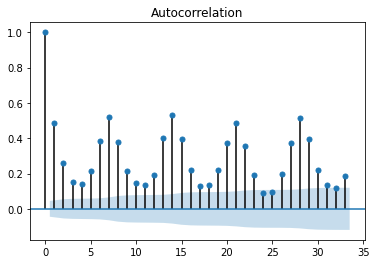

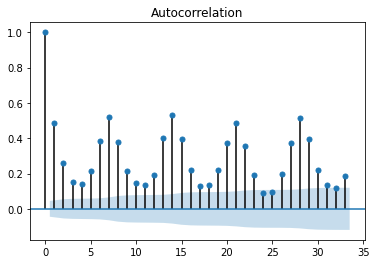

In [0]:
# Plot the Autocorrelation Function
plot_acf(HOBBIESSet)

In [0]:
# Calculate mean and standard deviation
rolmean = HOBBIESSet.rolling(window=365).mean()
rolstd = HOBBIESSet.rolling(window=365).std()

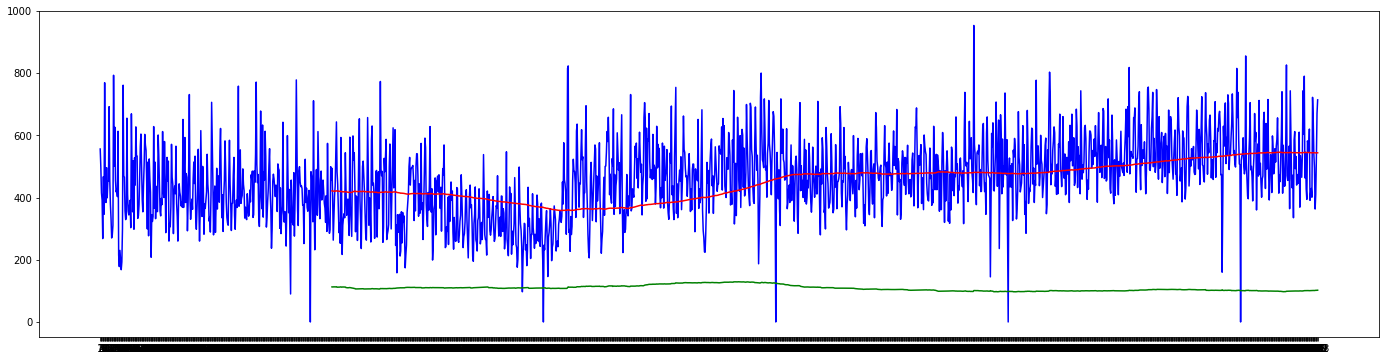

In [0]:
# Plot of the mean and the standard deviation
figure = plt.figure(figsize=(24,6))
orig = plt.plot(HOBBIESSet,color='blue',label='Test Data')
mean = plt.plot(rolmean,color='red',label='Mean')
std = plt.plot(rolstd, color='green',label='STD')
plt.show()

In [0]:
# This codes does a test statistic in the data
print('Results of Dickey-Fuller Test')
dftest = adfuller(HOBBIESSet['HOBBIES'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4],index=['Test Statistic', 'P-Values', '#LagUsed', '# of Obs'])
for key,value in dftest[4].items():
  dfoutput['Critical value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test
Test Statistic            -2.901422
P-Values                   0.045183
#LagUsed                  26.000000
# of Obs                1886.000000
Critical value (1%)       -3.433822
Critical value (5%)       -2.863074
Critical value (10%)      -2.567586
dtype: float64


In [0]:
# Implementation of the differentiation method to try to make the data stationary
HOBBIESSet_diff = HOBBIESSet.diff(periods=1)
HOBBIESSet_diff = HOBBIESSet_diff[1:]
HOBBIESSet_diff.head()

,HOBBIES
2,-58.0
3,-83.0
4,-23.0
5,-124.0
6,199.0


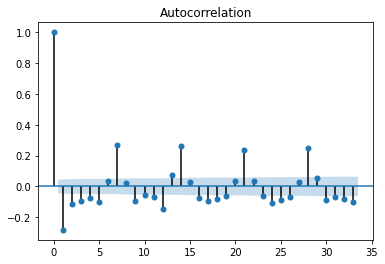

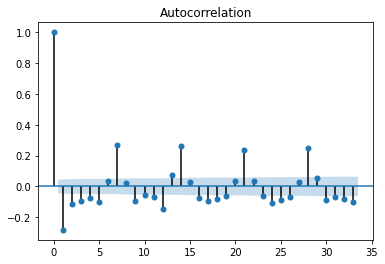

In [0]:
# Plot of the acf with the differentiated data
plot_acf(HOBBIESSet_diff)

In [0]:
# mean and std of the differantiated data
rolmean_diff = HOBBIESSet_diff.rolling(window=365).mean()
rolstd_diff = HOBBIESSet_diff.rolling(window=365).std()

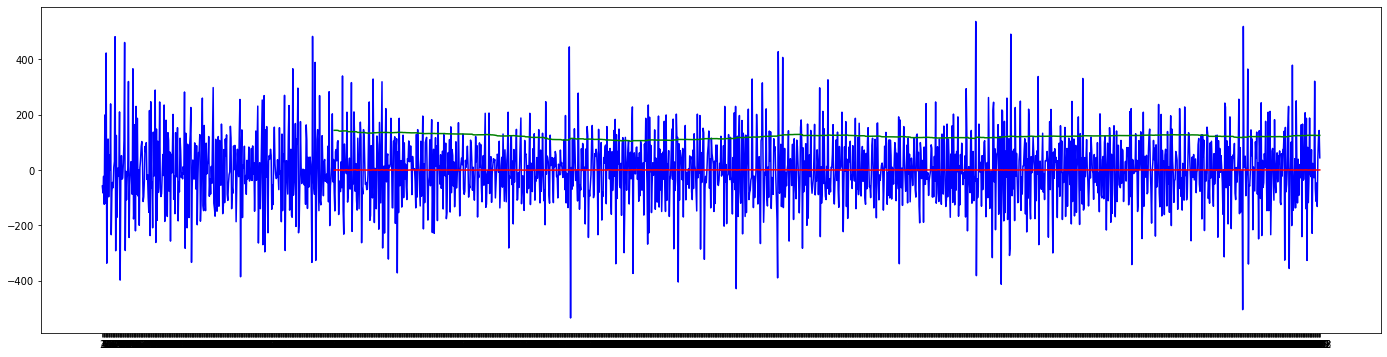

In [0]:
figure = plt.figure(figsize=(24,6))
orig = plt.plot(HOBBIESSet_diff,color='blue',label='Test Data')
mean = plt.plot(rolmean_diff,color='red',label='Mean')
std = plt.plot(rolstd_diff, color='green',label='STD')
plt.show(block=False)

In [0]:
# Test statistic of the defferentiated data
print('Results of Dickey-Fuller Test')
dftest = adfuller(HOBBIESSet_diff['HOBBIES'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4],index=['Test Statistic', 'P-Values', '#LagUsed', '# of Obs'])
for key,value in dftest[4].items():
  dfoutput['Critical value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test
Test Statistic         -1.447522e+01
P-Values                6.506312e-27
#LagUsed                2.600000e+01
# of Obs                1.885000e+03
Critical value (1%)    -3.433824e+00
Critical value (5%)    -2.863075e+00
Critical value (10%)   -2.567587e+00
dtype: float64


In [0]:
# Split the data into train and test
X = HOBBIESSet_diff.values
train = X[1500:1887]
test = X[1887:]
print(train.size)
print(test.size)

387
25


In [0]:
# Traind the ARIMA model with the train data
model_arima = ARIMA(train,order=[15,1,1])
model_arima_fit = model_arima.fit()
model_arima_fit.aic

4592.546216069507

In [0]:
# Made prediction with the forecast methos thats included in the ARiMA library
predicitons = model_arima_fit.forecast(steps=25)

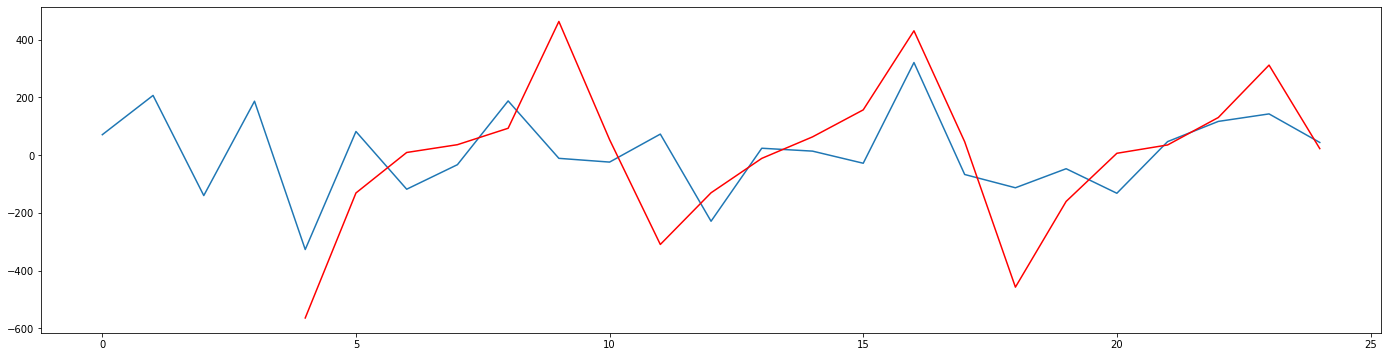

In [0]:
# Plot of the results
pred = pd.DataFrame(predictions)
pred = pred.shift(4)
figure = plt.figure(figsize=(24,6))
plt.plot(test)
plt.plot(pred, color='red')

In [0]:
# Calculation of the MSE and MAE
mse = 0
mae = 0
for i in range(len(predictions)):
  mse += (test[i] - predictions[i])**2
  mae += abs(test[i] - predictions[i])

mse = mse/len(predictions)
mae = mae/len(predictions)
print(mse)
print(mae)

[87561.8594172]
[239.97426487]


In [0]:
# Traind the AR model
model_ar = AR(train)
model_ar_fit = model_ar.fit()

In [0]:
# Made predicitons with the predict function
predictions = model_ar_fit.predict(start=341,end=365)

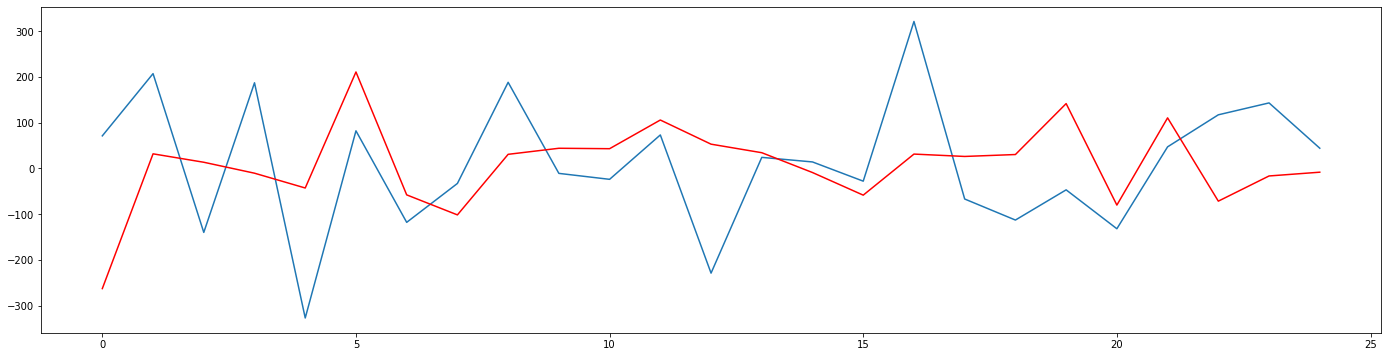

In [0]:
# Plot of the results
pred = pd.DataFrame(predictions)
figure = plt.figure(figsize=(24,6))
plt.plot(test)
plt.plot(pred, color='red')

In [0]:
# Calculation of the MSE and MAE for the AR model used
mse = 0
mae = 0
for i in range(len(predictions)):
  mse += (test[i] - predictions[i])**2
  mae += abs(test[i] - predictions[i])

mse = mse/len(predictions)
mae = mae/len(predictions)
print(mse)
print(mae)

[25751.50174228]
[131.57189954]


In [0]:
# FOODS
# Save category name
colName = 'FOODS'
# Add the sales of all the products belonging to this category for each day
FOODSSet = sets['FOODS'].sum()
# Convert the grouped object to a DataFrame
FOODSSet = pd.DataFrame(FOODSSet)
# Drop all unecessary columns
FOODSSet = FOODSSet.drop(['id','item_id','dept_id','cat_id','store_id','state_id'])
FOODSSet = FOODSSet.T
# Rename columns of DataFrame
for col in FOODSSet.columns:
    FOODSSet.rename(columns={col : col.split('_')[1]}, inplace = True)
FOODSSet = FOODSSet.T
FOODSSet.rename(columns={0 : colName }, inplace = True)
# Convert the resulting column to a numeric type
FOODSSet['FOODS'] = FOODSSet['FOODS'].apply(pd.to_numeric)
FOODSSet.head()

,FOODS
1,3239
2,3137
3,2008
4,2258
5,2032


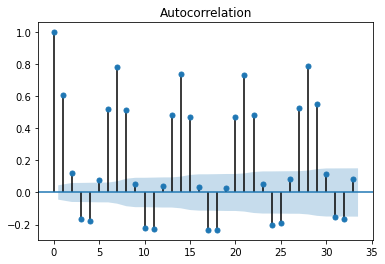

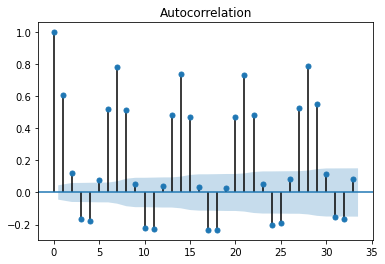

In [0]:
# Plot the Autocorrelation Function
plot_acf(FOODSSet)

In [0]:
# Calculate mean and standard deviation
rolmean = FOODSSet.rolling(window=365).mean()
rolstd = FOODSSet.rolling(window=365).std()

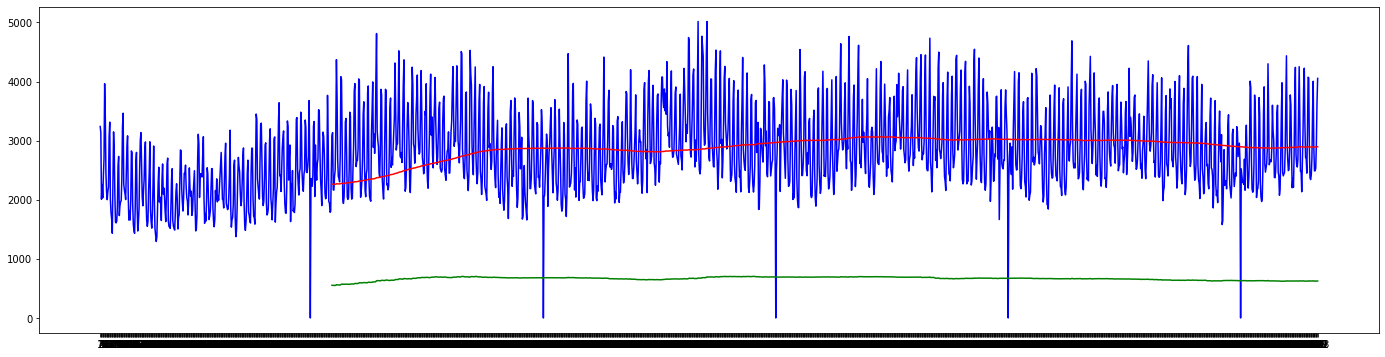

In [0]:
# Plot of the mean and the standard deviation
figure = plt.figure(figsize=(24,6))
orig = plt.plot(FOODSSet,color='blue',label='Test Data')
mean = plt.plot(rolmean,color='red',label='Mean')
std = plt.plot(rolstd, color='green',label='STD')
plt.show()

In [0]:
# This codes does a test statistic in the data
print('Results of Dickey-Fuller Test')
dftest = adfuller(FOODSSet['FOODS'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4],index=['Test Statistic', 'P-Values', '#LagUsed', '# of Obs'])
for key,value in dftest[4].items():
  dfoutput['Critical value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test
Test Statistic            -2.393879
P-Values                   0.143472
#LagUsed                  26.000000
# of Obs                1886.000000
Critical value (1%)       -3.433822
Critical value (5%)       -2.863074
Critical value (10%)      -2.567586
dtype: float64


In [0]:
# Implementation of the differentiation method to try to make the data stationary
FOODSSet_diff = FOODSSet_diff.diff(periods=1)
FOODSSet_diff = FOODSSet_diff[1:]
FOODSSet_diff.head()

,FOODS
3,-1027.0
4,1379.0
5,-476.0
6,601.0
7,-89.0


In [0]:
# Test statistic of the defferentiated data
print('Results of Dickey-Fuller Test')
dftest = adfuller(FOODSSet_diff['FOODS'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4],index=['Test Statistic', 'P-Values', '#LagUsed', '# of Obs'])
for key,value in dftest[4].items():
  dfoutput['Critical value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test
Test Statistic         -1.489213e+01
P-Values                1.551642e-27
#LagUsed                2.600000e+01
# of Obs                1.884000e+03
Critical value (1%)    -3.433826e+00
Critical value (5%)    -2.863075e+00
Critical value (10%)   -2.567587e+00
dtype: float64


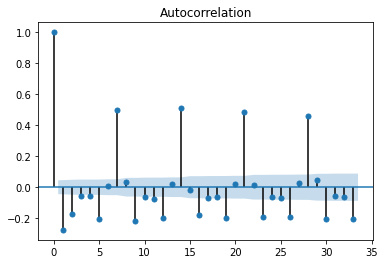

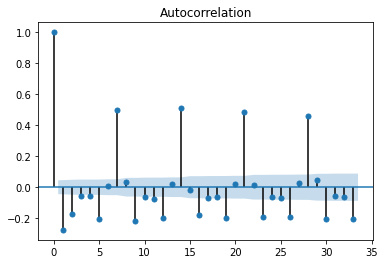

In [0]:
# Plot the acf of the differentiated data
plot_acf(FOODSSet_diff)

In [0]:
# Mean and STD of the differentiated data
rolmean_diff = FOODSSet_diff.rolling(window=365).mean()
rolstd_diff = FOODSSet_diff.rolling(window=365).std()

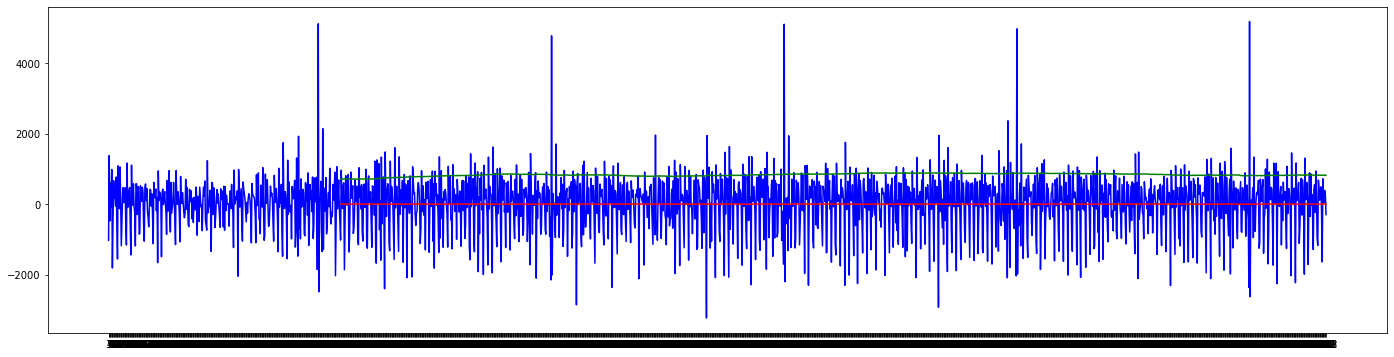

In [0]:
figure = plt.figure(figsize=(24,6))
orig = plt.plot(FOODSSet_diff,color='blue',label='Test Data')
mean = plt.plot(rolmean_diff,color='red',label='Mean')
std = plt.plot(rolstd_diff, color='green',label='STD')
plt.show()

In [0]:
# Split the data into train and test sets
X = FOODSSet_diff.values
train = X[1522:1887]
test = X[1887:]
print(train.size)
print(test.size)

365
24


In [0]:
# Trained the AR model with the training dat  
model_ar = AR(train)
model_ar_fit = model_ar.fit()

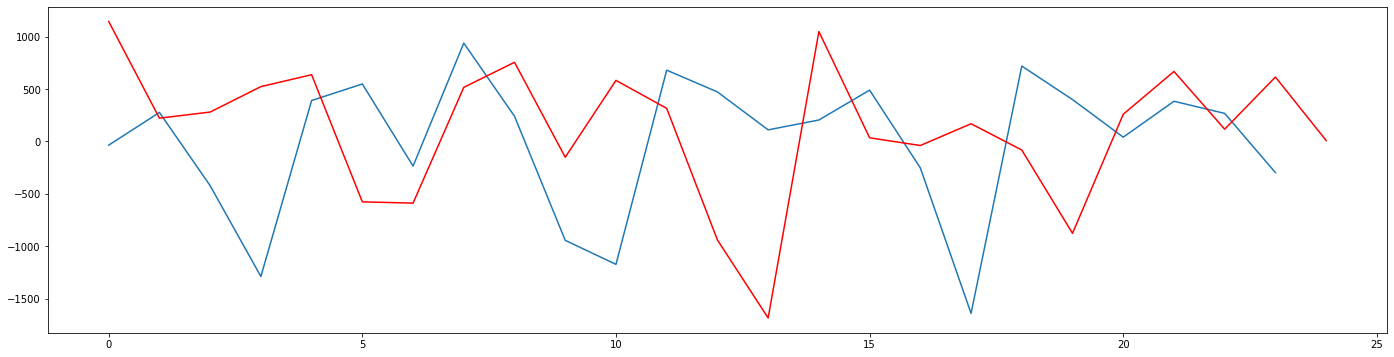

In [0]:
# Made predictions with the trained model
predictions = model_ar_fit.predict(start=341,end=365)
pred = pd.DataFrame(predictions)
figure = plt.figure(figsize=(24,6))
plt.plot(test)
plt.plot(pred, color='red')

In [0]:
# Calculated the MSE and MAE of the trained model
mse = 0
mae = 0
for i in range(len(test)):
  mse += (test[i] - predictions[i])**2
  mae += abs(test[i] - predictions[i])

mse = mse/len(predictions)
mae = mae/len(predictions)
print(mse)
print(mae)

[945767.17964258]
[780.23721058]


In [0]:
# HOUSEHOLD
# Save category name
colName = 'HOUSEHOLD'
# Add the sales of all the products belonging to this category for each day
HOUSEHOLDSet = sets['HOUSEHOLD'].sum()
# Convert the grouped object to a DataFrame
HOUSEHOLDSet = pd.DataFrame(HOUSEHOLDSet)
# Drop all unecessary columns
HOUSEHOLDSet = HOUSEHOLDSet.drop(['id','item_id','dept_id','cat_id','store_id','state_id'])
HOUSEHOLDSet = HOUSEHOLDSet.T
# Rename columns of DataFrame
for col in HOUSEHOLDSet.columns:
    HOUSEHOLDSet.rename(columns={col : col.split('_')[1]}, inplace = True)
HOUSEHOLDSet = HOUSEHOLDSet.T
HOUSEHOLDSet.rename(columns={0 : colName }, inplace = True)
# Convert the resulting column to a numeric type
HOUSEHOLDSet['HOUSEHOLD'] = HOUSEHOLDSet['HOUSEHOLD'].apply(pd.to_numeric)
HOUSEHOLDSet.head()

,HOUSEHOLD
1,542
2,520
3,393
4,401
5,330


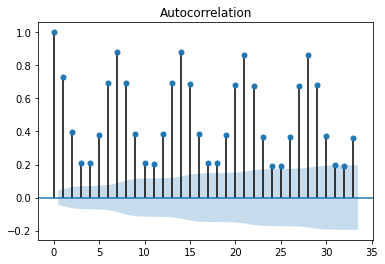

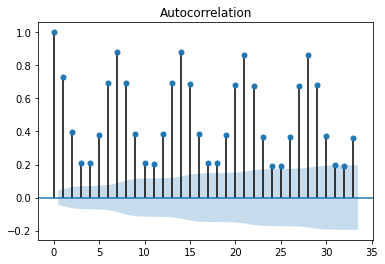

In [0]:
# Plot the Autocorrelation Function
plot_acf(HOUSEHOLDSet)

In [0]:
# Calculate mean and standard deviation
rolmean = HOUSEHOLDSet.rolling(window=365).mean()
rolstd = HOUSEHOLDSet.rolling(window=365).std()

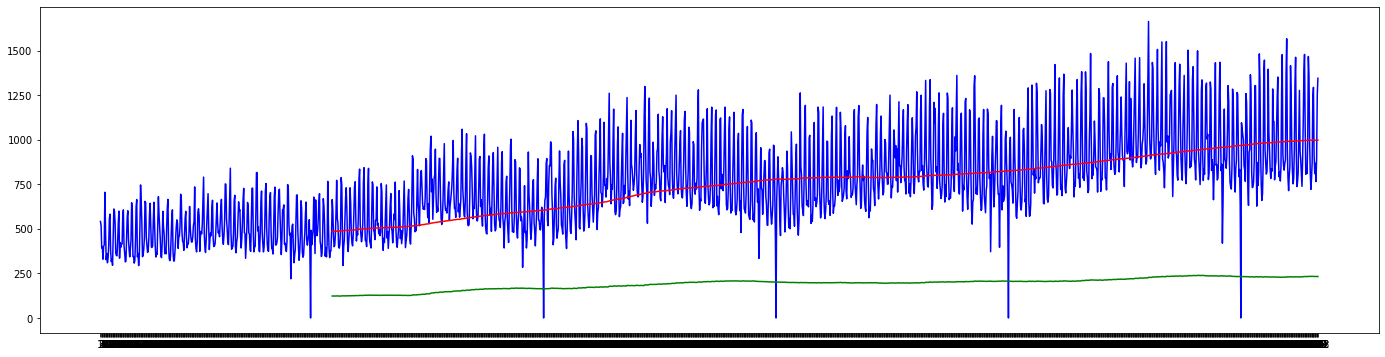

In [0]:
# Plot of the mean and the standard deviation
figure = plt.figure(figsize=(24,6))
orig = plt.plot(HOUSEHOLDSet,color='blue',label='Test Data')
mean = plt.plot(rolmean,color='red',label='Mean')
std = plt.plot(rolstd, color='green',label='STD')
plt.show()

In [0]:
# This codes does a test statistic in the data
print('Results of Dickey-Fuller Test')
dftest = adfuller(HOUSEHOLDSet['HOUSEHOLD'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4],index=['Test Statistic', 'P-Values', '#LagUsed', '# of Obs'])
for key,value in dftest[4].items():
  dfoutput['Critical value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test
Test Statistic            -1.469403
P-Values                   0.548589
#LagUsed                  26.000000
# of Obs                1886.000000
Critical value (1%)       -3.433822
Critical value (5%)       -2.863074
Critical value (10%)      -2.567586
dtype: float64


In [0]:
# Implementation of the differentiation method to try to make the data stationary
HOUSEHOLDSet_diff = HOUSEHOLDSet.diff(periods=1)
HOUSEHOLDSet_diff = HOUSEHOLDSet_diff[1:]
HOUSEHOLDSet_diff.head()

,HOUSEHOLD
2,-22.0
3,-127.0
4,8.0
5,-71.0
6,72.0


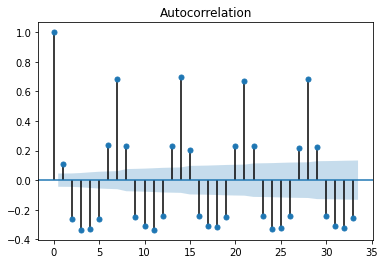

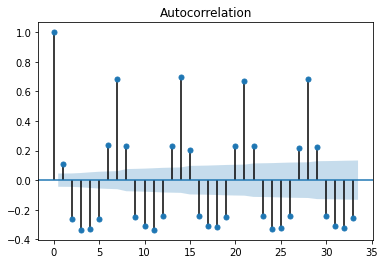

In [0]:
# Plot the acf of the differentiated data
plot_acf(HOUSEHOLDSet_diff)

In [0]:
# Mean and std of the defferentiated data
rolmean_diff = HOUSEHOLDSet_diff.rolling(window=365).mean()
rolstd_diff = HOUSEHOLDSet_diff.rolling(window=365).std()

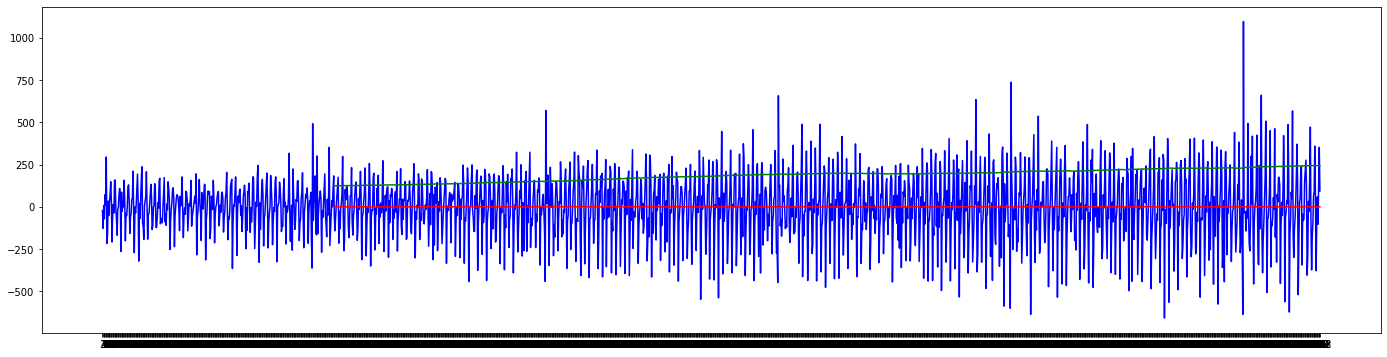

In [0]:
figure = plt.figure(figsize=(24,6))
orig = plt.plot(HOUSEHOLDSet_diff,color='blue',label='Test Data')
mean = plt.plot(rolmean_diff,color='red',label='Mean')
std = plt.plot(rolstd_diff, color='green',label='STD')
plt.show()

In [0]:
# Split the data into train and test
X = HOUSEHOLDSet_diff.values
train = X[1522:1887]
test = X[1887:]
print(train.size)
print(test.size)

365
25


In [0]:
# Trained the AR model with the training data
model_ar = AR(train)
model_ar_fit = model_ar.fit()

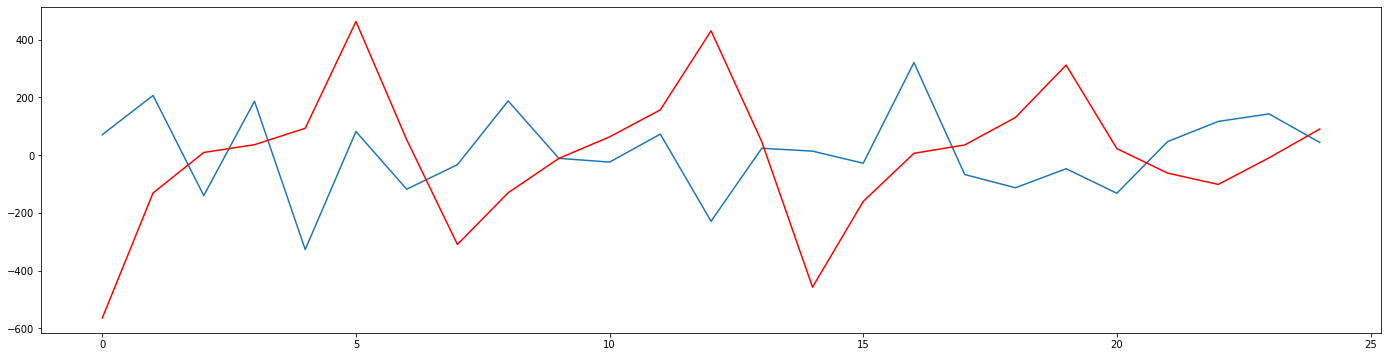

In [0]:
# Made precdictions with the trained AR model
predictions = model_ar_fit.predict(start=341,end=365)
pred = pred.shift(5)
pred = pd.DataFrame(predictions)
figure = plt.figure(figsize=(24,6))
plt.plot(test)
plt.plot(pred, color='red')

In [0]:
# Calculated the MSE and MAE of the predictions made
mse = 0
mae = 0
for i in range(len(test)):
  mse += (test[i] - predictions[i])**2
  mae += abs(test[i] - predictions[i])

mse = mse/len(predictions)
mae = mae/len(predictions)
print(mse)
print(mae)

[147172.55870382]
[316.77051522]
